## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()

/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

In [4]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [5]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

In [6]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [7]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        2 if "arg2" in x.casefold() else
        3 if "arg3" in x.casefold() else
        4 if "arg4" in x.casefold() else
     #   5 if "arg5" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro') & (df_features.label != 5)]
df_features.label.value_counts()

label
1    7052
0    4154
2    1714
3     188
4     137
Name: count, dtype: int64

In [8]:
################################
# Só ARG0 e ARG1 
################################

# df_features['label'] = df_features.label.apply(
#     lambda x: 
#         0 if "arg0" in x.casefold() else
#         1 if "arg1" in x.casefold() else
#         "erro"
        
# )

# df_features['label'].value_counts()

# df_features = df_features[
#     (df_features.label != 'erro')]
# df_features.label.value_counts()

In [9]:
df_features.label = df_features.label.astype('int')

In [10]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
2                        sci_3
3                        sci_1
4                        sci_0
                 ...          
13241    PropBankBr_v1.1_Dep_1
13242    PropBankBr_v1.1_Dep_2
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 13245, dtype: object

In [11]:
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner,stratify-column
0,sci,1,ter,person,0,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER,sci_0
1,sci,4,fazer,isso,1,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa,sci_1
2,sci,4,fazer,universidade,3,obl,feito,fazer,VERB,VERB,nsa,universidade,universidade,NOUN,NOUN,nsa,sci_3
3,sci,12,acontecer,isso,1,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa,sci_1
4,sci,16,entender,otimista,0,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa,sci_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,1,nao_tem_dep,é,ser,AUX,AUX,nsa,Abram_Szajman,Abram_Szajman,PROPN,PROPN,LOC,PropBankBr_v1.1_Dep_1
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,2,ROOT,é,ser,AUX,AUX,nsa,presidente,presidente,NOUN,NOUN,nsa,PropBankBr_v1.1_Dep_2
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,0,nsubj,surpreendeu,surpreender,VERB,VERB,nsa,que,que,PRON,PRON,nsa,PropBankBr_v1.1_Dep_0
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,1,obj,surpreendeu,surpreender,VERB,VERB,nsa,galera,galera,NOUN,NOUN,nsa,PropBankBr_v1.1_Dep_1


In [12]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

### split

In [13]:
df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner',
       'stratify-column'],
      dtype='object')

In [14]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [15]:
len_emb= 300

model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')

In [16]:
# # Obter embeddings para as palavras em cada coluna
def get_embedding(word):
    
    # da pau quando nao tem a palavra
    try:
        return model[word]
    except Exception as e:
        return [-1000 for n in range(len_emb)] 

embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

100%|██████████| 13245/13245 [00:00<00:00, 587029.71it/s]
/tmp/ipykernel_1120350/3527302311.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_1120350/3527302311.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_1120350/3527302311.py:11: PerformanceWarning: DataFrame is highly fragmented.  Th

In [17]:
cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,child_tag_PUNCT,child_tag_SCONJ,child_tag_SYM,child_tag_VERB,child_tag_X,child_ner_LOC,child_ner_MISC,child_ner_ORG,child_ner_PER,child_ner_nsa
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
13242,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
13244,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [18]:
X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
X_enc[[f"emb_{n}_lemma_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

/tmp/ipykernel_1120350/229788104.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
/tmp/ipykernel_1120350/229788104.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
/tmp/ipykernel_1120350/229788104.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [19]:
X_enc

,dep_ROOT,dep_acl,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,...,emb_291_lemma_parent,emb_292_lemma_parent,emb_293_lemma_parent,emb_294_lemma_parent,emb_295_lemma_parent,emb_296_lemma_parent,emb_297_lemma_parent,emb_298_lemma_parent,emb_299_lemma_parent,emb_300_lemma_parent
0,False,False,False,False,False,False,False,False,False,False,...,0.219041,-0.231110,-0.085020,0.103719,-0.328588,0.110025,-0.363171,0.147115,0.625632,0.461527
1,False,False,False,False,False,False,False,False,False,False,...,0.087708,0.206846,0.027924,0.229824,-0.494868,0.276404,-0.000887,-0.593449,-0.297460,0.165594
2,False,False,False,False,False,False,False,False,False,False,...,0.087708,0.206846,0.027924,0.229824,-0.494868,0.276404,-0.000887,-0.593449,-0.297460,0.165594
3,False,False,False,False,False,False,False,False,False,False,...,-0.319974,-0.125192,-0.293197,0.418679,-0.340952,0.146779,-0.150461,-0.079200,-0.341857,-0.072542
4,False,False,False,False,False,False,False,False,False,False,...,-0.117962,0.311994,-0.460692,-0.006343,-0.009543,0.061861,0.048412,-0.004028,-0.015190,0.344882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,False,False,False,False,False,False,False,False,False,False,...,0.063189,0.030607,0.485018,0.383235,-0.283470,-0.418072,0.091419,-0.048462,-0.033289,0.349739
13242,True,False,False,False,False,False,False,False,False,False,...,0.063189,0.030607,0.485018,0.383235,-0.283470,-0.418072,0.091419,-0.048462,-0.033289,0.349739
13243,False,False,False,False,False,False,False,False,False,False,...,0.408305,0.153191,-0.167033,-0.235358,-0.489161,-0.309095,0.112066,0.083798,-0.012562,0.180984
13244,False,False,False,False,False,False,False,False,False,False,...,0.408305,0.153191,-0.167033,-0.235358,-0.489161,-0.309095,0.112066,0.083798,-0.012562,0.180984


In [20]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42, stratify=df_features.drop(propbank_index)['label'])


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])

In [21]:
# remover features que nao variam no treino
features_std_0 = X_train.columns[X_train.std() == 0].tolist()
X_train.drop(features_std_0,axis = 1, inplace=True)
X_test.drop(features_std_0,axis = 1, inplace=True)

In [22]:
# def remove_highly_correlated_features(df, threshold):
#     """
#     Remove features altamente correlacionadas de um dataframe com base em um threshold.

#     :param df: DataFrame contendo as features.
#     :param threshold: Valor de correlação acima do qual as features serão consideradas altamente correlacionadas.
#     :return: Lista de features a serem removidas.
#     """
#     # Calcula a matriz de correlação
#     corr_matrix = df.corr().abs()
    
#     # Seleciona a metade superior da matriz de correlação
#     upper = corr_matrix.where(
#         np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
#     )
    
#     # Encontra features com correlação maior que o threshold
#     to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
#     return to_drop

# highly_corr_feats = remove_highly_correlated_features(X_train, threshold = .95)
# X_train.drop(highly_corr_feats,axis =1, inplace = True)
# X_test.drop(highly_corr_feats,axis =1, inplace = True)

In [24]:
import scipy.stats as st

#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = None#RandomOverSampler(sampling_strategy='minority',random_state=random_seed)
scaler = StandardScaler()

estimator = XGBClassifier(
    device = 'cuda',
 #tree_method = 'hist'
    )

pipeline_steps = [
    ('scaling', scaler),
    ('sampling', sampler),
    ('selecting', selector),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)


# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
           # 'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
#            'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80]
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=StratifiedKFold(n_splits=10), 
    verbose=4,
    #n_jobs=-1, 
    n_iter=20, 
    #error_score = "raise",
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.339 total time=  56.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.532 total time=  59.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.622 total time=  51.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.624 total time=  56.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.667 total time=  50.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.709 total time=  51.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.660 total time=  54.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.616 total time=  53.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.655 total time=  55.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.691 total time=  49.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.341 total time=  20.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.518 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.616 total time=  22.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.563 total time=  21.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.609 total time=  19.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.657 total time=  17.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.655 total time=  19.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.604 total time=  21.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.608 total time=  23.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.605 total time=  22.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.327 total time=  26.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.410 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.475 total time=  15.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.477 total time=  20.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.476 total time=  23.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.466 total time=  22.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.456 total time=  23.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.471 total time=  23.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.473 total time=  23.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.449 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.317 total time=   8.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.423 total time=   7.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.530 total time=   7.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.584 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.530 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.592 total time=  10.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.598 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.575 total time=  10.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.577 total time=   9.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.554 total time=   9.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.330 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.410 total time=  22.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.479 total time=  20.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.474 total time=  26.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.476 total time=  19.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.464 total time=  16.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.460 total time=  18.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.473 total time=  24.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.474 total time=  20.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.460 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.323 total time=   6.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.401 total time=   6.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.528 total time=   5.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.458 total time=   6.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.454 total time=   6.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.446 total time=   7.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.451 total time=   5.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.457 total time=   8.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.437 total time=   6.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.468 total time=   5.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.325 total time=  25.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.408 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.469 total time=  14.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.476 total time=  29.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.474 total time=  25.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.464 total time=  27.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.468 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.467 total time=  23.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.477 total time=  20.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.470 total time=  15.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.312 total time=  10.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.500 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.534 total time=  11.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.584 total time=  13.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.519 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.556 total time=   9.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.554 total time=  10.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.587 total time=  12.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.559 total time=  16.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.542 total time=  12.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.331 total time=  35.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.413 total time=  24.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.537 total time=  27.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.530 total time=  24.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.513 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.573 total time=  20.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.539 total time=  30.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.537 total time=  24.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.558 total time=  28.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.521 total time=  31.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.365 total time=  17.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.597 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.693 total time=  24.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.725 total time=  19.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.752 total time=  17.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.717 total time=  20.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.714 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.662 total time=  18.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.764 total time=  15.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.696 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.367 total time=  40.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.556 total time=  38.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.685 total time=  31.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.723 total time=  42.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.700 total time=  35.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.713 total time=  40.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.712 total time=  41.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.643 total time=  31.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.751 total time=  41.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.707 total time=  31.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.328 total time=  10.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.503 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.575 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.597 total time=  13.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.552 total time=  10.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.573 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.576 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.565 total time=  12.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.583 total time=  13.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.556 total time=   9.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.323 total time=  25.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.411 total time=  29.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.477 total time=  23.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.473 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.480 total time=  26.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.471 total time=  21.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.466 total time=  28.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.473 total time=  28.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.482 total time=  29.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.459 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.327 total time=  16.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.405 total time=  14.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.475 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.468 total time=  17.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.470 total time=  19.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.464 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.460 total time=  15.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.462 total time=  15.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.486 total time=  10.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.452 total time=  11.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.326 total time=  13.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.411 total time=  16.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.527 total time=  13.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.529 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.474 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.470 total time=  18.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.541 total time=  12.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.471 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.478 total time=  14.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.521 total time=  11.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.336 total time=  33.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.518 total time=  29.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.598 total time=  31.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.612 total time=  33.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.592 total time=  37.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.651 total time=  23.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.557 total time=  29.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.644 total time=  24.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.587 total time=  29.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.598 total time=  26.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.327 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.471 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.534 total time=   9.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.549 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.510 total time=  14.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.582 total time=  14.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.575 total time=   9.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.552 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.568 total time=  11.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.546 total time=  11.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.337 total time=  29.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.535 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.636 total time=  19.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.630 total time=  23.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.700 total time=  24.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.698 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.637 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.619 total time=  28.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.695 total time=  27.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.680 total time=  23.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.337 total time=  23.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.521 total time=  17.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.603 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.609 total time=  15.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.594 total time=  18.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.663 total time=  19.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.641 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.603 total time=  18.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.596 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.620 total time=  16.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   8   43   59   60   66   79   82   83   88   97  110  114  117  120
  121  136  144  156  159  162  163  169  180  189  199  203  211  212
  213  218  224  225  239  253  267  268  273  274  304  307  311  329
  366  381  384  427  449  450  451  454  459  468  482  492  498  545
  565  587  627  632  666  668  672  673  674  689  692  693  705  717
  734  749  767  795  798  818  820  831  841  846  848  850  874  879
  890  906  939  948  961  973  980  982 1026 1059 1065 1095 1105 1137
 1153 1184 1191 1199 1210 1213 1221 1237 1304 1306 1326 1352 1374 1406
 1415 1434 1448 1453 1465 1467 1471 1477 1481 1513 1567 1583 1593 1605
 1609 1647 1651 1678 1690 1695 1699 1709 1711 1721 1725 1730 1747 1775
 1776 1790 1799 1865 1877 1912 1913 1914 1922 1931 1942 1987 2003 2013
 2041 2059 2062 2068 2069 2072 2079 2086 2087 2088 2097 2101 2106 2134
 2136 

[CV 1/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.321 total time=  16.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   41   45   68   89   91  101  115  119  126  127  172  178  182
  204  223  226  231  238  242  251  260  272  278  283  294  317  325
  347  349  382  400  407  411  463  479  496  499  501  502  513  526
  531  550  569  590  593  597  681  691  715  729  752  801  815  817
  833  835  839  851  867  871  880  889  895  920  928  934  936  992
  999 1004 1008 1011 1012 1020 1032 1040 1043 1045 1070 1114 1121 1142
 1144 1177 1190 1193 1289 1348 1357 1404 1436 1447 1454 1455 1459 1492
 1499 1514 1550 1579 1582 1589 1621 1637 1655 1676 1687 1710 1756 1760
 1765 1766 1779 1789 1792 1796 1797 1825 1839 1868 1905 1928 1976 1982
 1991 1998 2007 2020 2040 2056 2083 2092 2096 2098 2111 2114 2138 2161
 2212 2225 2242 2249 2264 2269 2271 2291 2309 2347 2366 2376 2381 2391
 2398 2405 2412 2413 2417 2427 2474 2483 2490 2498 2533 2559 2563 2590
 2618 

[CV 2/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.436 total time=  14.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  58  102  134  139  145  147  161  188  191  202  207  210  219  220
  234  254  255  259  270  305  340  361  365  397  402  457  487  509
  529  535  541  563  574  615  634  645  653  663  667  721  733  786
  791  813  816  832  847  855  896  909  937  977 1006 1019 1041 1048
 1058 1071 1089 1110 1165 1167 1239 1240 1241 1255 1256 1285 1299 1323
 1349 1369 1401 1407 1411 1414 1432 1442 1457 1462 1503 1520 1521 1542
 1544 1581 1603 1624 1626 1680 1712 1724 1734 1746 1794 1806 1838 1845
 1848 1852 1858 1862 1863 1874 1879 1935 1943 2004 2022 2055 2057 2081
 2089 2095 2105 2116 2117 2153 2163 2167 2178 2224 2250 2263 2276 2305
 2320 2336 2390 2394 2395 2404 2424 2440 2494 2596 2600 2603 2623 2629
 2638 2685 2701 2738 2752 2786 2792 2795 2805 2814 2820 2826 2827 2834
 2840 2868 2869 2872 2877 2911 2940 2963 2977 2982 2988 3008 3014 3018
 3026 

[CV 3/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.539 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   77   81  111  125  128  130  131  153  170  195  216  227  230
  235  244  276  315  316  320  328  330  333  346  352  356  372  391
  431  445  446  453  455  488  505  540  556  608  609  620  635  644
  664  665  677  695  704  719  753  757  766  774  803  804  845  849
  925  938  951  981  997 1016 1060 1064 1084 1086 1099 1104 1161 1171
 1175 1179 1205 1225 1228 1242 1269 1270 1294 1317 1344 1364 1366 1384
 1395 1396 1413 1445 1451 1466 1487 1510 1511 1533 1557 1572 1600 1602
 1606 1629 1662 1704 1722 1731 1787 1802 1817 1827 1840 1849 1853 1887
 1938 1956 1981 1984 1986 2001 2028 2048 2049 2099 2123 2165 2183 2230
 2236 2241 2258 2290 2321 2342 2371 2415 2447 2460 2462 2484 2505 2509
 2518 2524 2535 2539 2544 2553 2556 2574 2578 2583 2593 2650 2671 2700
 2708 2741 2809 2866 2879 2900 2925 2926 2933 2986 3001 3016 3017 3019
 3031 

[CV 4/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.561 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  33   52   56   64   86  106  158  173  194  229  243  249  303  310
  338  355  363  364  389  410  436  542  547  575  630  639  660  676
  688  696  751  823  837  876  932  953  954  993 1001 1015 1024 1030
 1079 1093 1094 1115 1119 1162 1180 1186 1198 1203 1220 1249 1251 1262
 1273 1280 1319 1320 1325 1372 1393 1408 1421 1431 1446 1452 1456 1458
 1484 1504 1537 1549 1601 1610 1625 1630 1631 1650 1701 1720 1780 1782
 1826 1836 1844 1859 1884 1894 1898 1904 1933 1957 1966 2005 2014 2038
 2053 2063 2080 2109 2119 2143 2157 2188 2199 2211 2234 2260 2278 2344
 2348 2357 2364 2385 2388 2420 2431 2442 2445 2481 2485 2545 2552 2579
 2594 2661 2682 2689 2696 2725 2729 2753 2759 2799 2808 2812 2847 2852
 2891 2931 2939 2967 2991 2997 3041 3043 3063 3068 3087 3093 3120 3124
 3136 3159 3162 3174 3178 3229 3260 3267 3306 3312 3380 3390 3440 3484
 3504 

[CV 5/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.548 total time=  21.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   62   69   76   78   80   92  124  129  132  138  141  160
  183  197  215  237  246  280  289  290  293  300  327  331  337  343
  344  357  393  413  423  426  435  469  493  517  533  538  560  592
  602  629  643  656  669  694  700  716  718  779  785  790  793  794
  799  821  852  853  860  865  873  931 1029 1037 1067 1072 1075 1083
 1091 1112 1127 1160 1166 1181 1192 1202 1286 1292 1316 1321 1331 1346
 1376 1387 1389 1424 1433 1449 1461 1464 1490 1506 1523 1528 1561 1580
 1608 1652 1672 1681 1706 1737 1750 1757 1791 1805 1820 1867 1872 1873
 1918 1955 2002 2025 2084 2100 2107 2122 2139 2181 2214 2217 2226 2231
 2251 2254 2255 2288 2324 2329 2330 2331 2350 2356 2386 2441 2461 2465
 2475 2546 2555 2606 2612 2635 2636 2655 2658 2694 2748 2762 2763 2779
 2785 2791 2806 2833 2848 2863 2871 2880 2888 2930 2943 2958 2974 2990
 3033 

[CV 6/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.591 total time=  21.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  63   72   74   84   96  149  165  168  184  185  206  217  245  277
  286  341  371  387  390  447  465  521  537  553  594  599  600  642
  646  722  741  758  775  796  843  859  863  870  892  900  910  912
  933  944  955  985  990  991 1002 1014 1018 1028 1035 1152 1159 1174
 1178 1209 1215 1226 1232 1261 1329 1363 1410 1469 1472 1480 1498 1501
 1505 1508 1518 1534 1539 1543 1554 1556 1570 1598 1622 1628 1641 1654
 1656 1658 1675 1677 1682 1735 1745 1751 1804 1854 1875 1888 1893 1897
 1902 1916 1952 1964 1983 2000 2026 2027 2034 2039 2065 2110 2131 2172
 2192 2266 2280 2300 2301 2341 2363 2393 2396 2401 2403 2408 2492 2502
 2526 2540 2547 2557 2558 2561 2625 2628 2662 2723 2751 2761 2811 2824
 2857 2862 2917 2924 2927 2959 3012 3042 3044 3055 3070 3092 3111 3132
 3151 3158 3166 3189 3199 3210 3218 3283 3315 3318 3319 3332 3379 3397
 3422 

[CV 7/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.552 total time=  23.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  50   51   67   87  103  104  112  123  133  148  154  201  214  257
  258  295  298  299  308  313  326  332  345  354  373  379  388  395
  405  439  440  471  484  515  516  519  570  572  579  596  611  670
  679  686  720  724  727  732  738  800  894  899  908  914  918  927
  950  996 1025 1034 1049 1054 1061 1101 1102 1103 1107 1132 1143 1150
 1168 1173 1176 1189 1197 1224 1231 1235 1254 1265 1291 1301 1307 1313
 1315 1337 1365 1370 1375 1400 1416 1430 1463 1509 1522 1535 1607 1612
 1627 1653 1674 1685 1715 1726 1753 1770 1773 1777 1786 1795 1798 1807
 1824 1837 1841 1860 1870 1895 1908 1911 1953 2017 2024 2066 2070 2115
 2121 2148 2164 2195 2200 2205 2209 2210 2222 2282 2332 2346 2349 2377
 2456 2479 2521 2580 2605 2713 2727 2737 2810 2813 2818 2837 2844 2854
 2856 2905 2918 2936 2945 2950 2966 3005 3023 3027 3054 3059 3074 3083
 3175 

[CV 8/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.568 total time=  19.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  37   42   95   98   99  100  108  109  116  140  152  187  196  233
  263  265  279  312  334  358  369  376  490  497  520  534  546  551
  557  566  583  619  623  744  780  789  825  864  869  884  946  958
  962 1053 1055 1073 1082 1117 1125 1164 1185 1212 1227 1229 1236 1351
 1381 1386 1397 1409 1419 1423 1426 1441 1470 1478 1489 1496 1516 1530
 1538 1569 1597 1613 1616 1620 1636 1643 1668 1723 1741 1774 1864 1885
 1910 1941 1988 2031 2060 2126 2140 2177 2184 2193 2213 2218 2232 2233
 2235 2238 2240 2243 2312 2322 2323 2351 2358 2375 2399 2406 2409 2429
 2454 2455 2471 2504 2511 2541 2586 2595 2607 2651 2666 2743 2744 2756
 2788 2794 2836 2839 2841 2842 2853 2882 2883 2892 2895 2901 2904 2906
 2908 2909 2947 2975 3020 3038 3049 3057 3085 3095 3122 3141 3142 3150
 3154 3167 3176 3198 3213 3232 3262 3270 3275 3277 3297 3393 3413 3429
 3435 

[CV 9/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.577 total time=  21.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   44   65   73   75  118  166  171  175  190  232  241  247  261
  262  266  309  321  377  398  464  466  473  476  483  528  536  555
  564  567  576  582  604  621  622  638  658  671  675  680  702  712
  723  728  731  743  781  787  802  819  829  844  862  893  919  923
  941  947  989 1005 1098 1106 1108 1113 1118 1128 1157 1163 1170 1206
 1216 1233 1266 1276 1361 1367 1420 1425 1444 1460 1479 1515 1524 1525
 1526 1529 1531 1540 1551 1614 1618 1634 1640 1642 1663 1667 1671 1679
 1688 1691 1727 1743 1769 1771 1831 1855 1869 1892 1907 1924 1929 1965
 1980 1990 2008 2011 2012 2021 2030 2075 2113 2127 2128 2130 2146 2171
 2173 2175 2182 2194 2202 2220 2229 2247 2297 2302 2303 2304 2369 2378
 2443 2450 2452 2478 2500 2503 2532 2534 2543 2564 2599 2637 2639 2644
 2648 2678 2707 2712 2724 2750 2764 2766 2831 2838 2846 2850 2855 2873
 2889 

[CV 10/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.564 total time=  23.3s
best_params {'estimator__colsample_bytree': 0.8741814405114897, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 1.8657005888603584, 'estimator__learning_rate': 0.40702359939599114, 'estimator__max_depth': 13, 'estimator__min_child_weight': 19.603635966648525, 'estimator__n_estimators': 30, 'estimator__subsample': 0.8526493722244973, 'selecting__percentile': 10}
best_score 0.6685891045594943


In [ ]:
# #################################################
# # teste
# #################################################


# selector = None#RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)

# sampler = RandomOverSampler(random_state=random_seed)
# scaler = StandardScaler(with_mean=False)

# estimator = XGBClassifier(
#     device = 'cuda',
# #    tree_method = 'hist'
#     )

# pipeline_steps = [
#     ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),
#     ('estimator',estimator)
#     ] 

# pipeline = Pipeline(steps = pipeline_steps)

# preprocess_pipeline = Pipeline(steps = [    ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),])


# X_train = preprocess_pipeline.fit_transform(X_train, y_train)



# # pipeline.fit(X_train, y_train)
# # model = pipeline

# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)


## predict

In [25]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       220
           1       0.76      0.85      0.80       322
           2       0.60      0.30      0.40        60
           3       0.00      0.00      0.00         7
           4       1.00      0.20      0.33         5

    accuracy                           0.76       614
   macro avg       0.63      0.43      0.47       614
weighted avg       0.75      0.76      0.75       614



<Axes: >

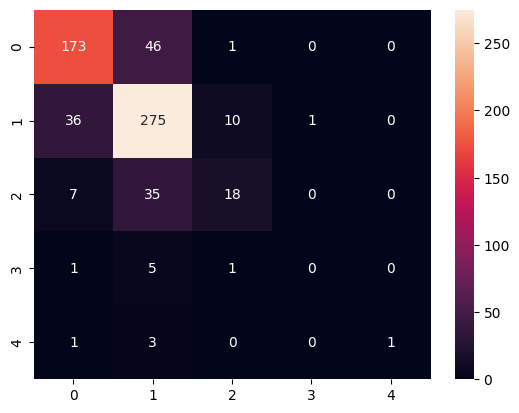

In [27]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g') # font size

In [28]:
# df_features_test = df_features.loc[y_test.index.tolist(), :]

# df_anl = pd.DataFrame({
#     "y_test": y_test.tolist(),
#     "y_pred": y_pred.tolist(),
#     "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
# })

# for cp_nm in df_anl.corpus_name.unique():
    
#     print(f"""###############################################
# # corpus name: {cp_nm}
# ###############################################
#           """)
    
#     df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
#     print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
#     cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
#     sns.heatmap(cm, annot=True, fmt='g') # font size
#     plt.show()
    
# y_test_s = y_test.copy()
# y_test_s['corpus']

### Featue importance

In [29]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['dep_ROOT', 'dep_advcl', 'dep_advmod', 'dep_ccomp', 'dep_conj', 'dep_iobj', 'dep_nao_tem_dep', 'dep_nsubj', 'dep_nsubj:pass', 'dep_obj', 'dep_obl', 'dep_parataxis', 'dep_xcomp', 'parent_text_,', 'parent_text_Chegamos', 'parent_text_Chegaram', 'parent_text_Confundem', 'parent_text_Da', 'parent_text_Entre', 'parent_text_Estamos', 'parent_text_Ficaram', 'parent_text_Iam', 'parent_text_Ir', 'parent_text_Li', 'parent_text_Retorna', 'parent_text_Sai', 'parent_text_Subiu', 'parent_text_Trabalhávamos', 'parent_text_Vamos', 'parent_text_Vim', 'parent_text_aberta', 'parent_text_aberto', 'parent_text_abertos', 'parent_text_aluga', 'parent_text_alugam', 'parent_text_ao', 'parent_text_apresentava', 'parent_text_assinando', 'parent_text_atuaram', 'parent_text_aumentando', 'parent_text_cair', 'parent_text_caiu', 'parent_text_caíram', 'parent_text_chega', 'parent_text_chegamos', 'parent_text_chegaram', 'parent_text_chegassem', 'parent_text_chego', 'parent_text_c

In [30]:
# Função para remover a parte após o último underscore
def remover_apos_ultimo_underscore(s):
    return "_".join(s.split("_")[:-1])

original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

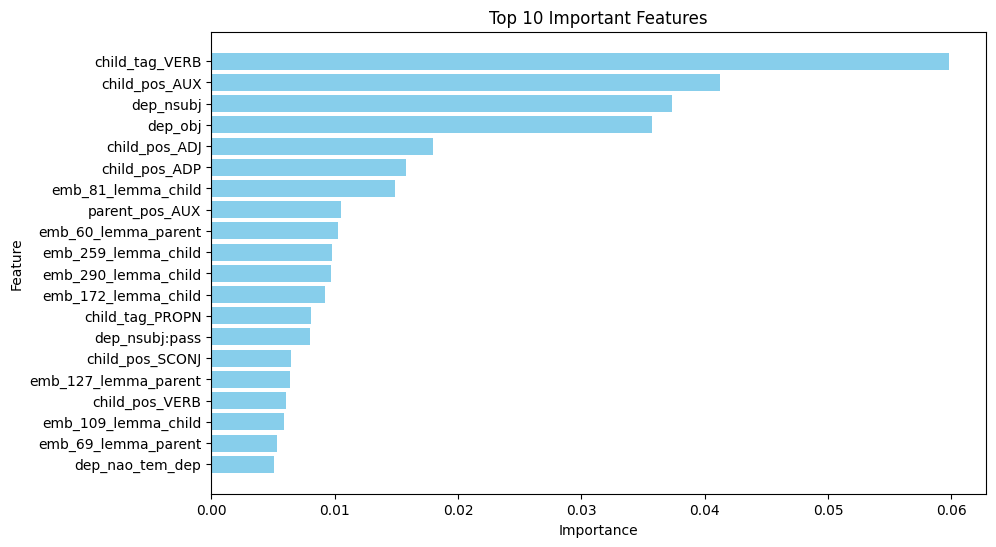

In [31]:
# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

# Ordenar o DataFrame pelo valor de importância
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


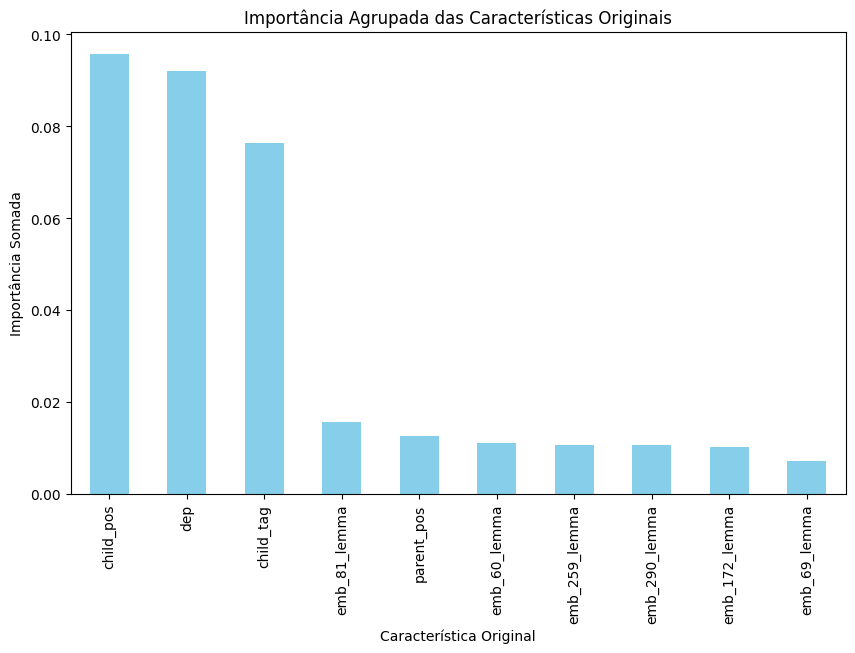

In [32]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
grouped_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Importância Agrupada das Características Originais')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [33]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

In [34]:

X_test_processed = X_test
for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test_processed)

scaling
sampling
selecting


In [35]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test_processed)

In [36]:
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)

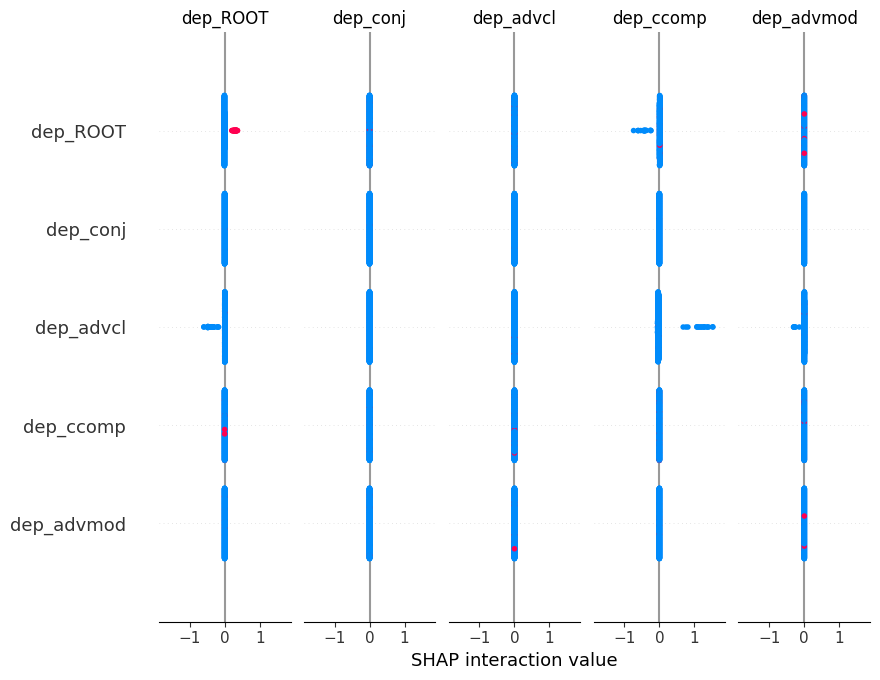

In [37]:
shap.summary_plot(shap_values, df_X_test_anl)
plt.show()

In [38]:
sh = explainer(X_test_processed)
sh.feature_names = selected_features

In [39]:
# ver quais features importaram em uma classificacao
shap.plots.waterfall(sh[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (892, 5)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [40]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(sh)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
shap.plots.bar(sh.max(0))

In [ ]:
# Dependence Plot para cada feature
for feature in [col for col in df_X_test_anl.columns if "dep_" in col]:
    shap.dependence_plot(feature, shap_values, df_X_test_anl)
    plt.show()